In [57]:
import pandas as pd
import numpy as np
import scipy as sp
import sympy as smp
import matplotlib.pyplot as plt

In [58]:
df = pd.read_csv("coil_position_data.txt")
df.columns=['w_t','LV']
df.head()

,w_t,LV
0,0.000001,3.000000
1,2.170418,3.023155
2,3.183280,3.037627
3,4.340836,3.049204
4,6.221865,3.057887


In [59]:
w_t = smp.symbols('w_t', positive=True) # 
LV_spline = smp.interpolating_spline( 3 , w_t , df['w_t'] , df['LV'])

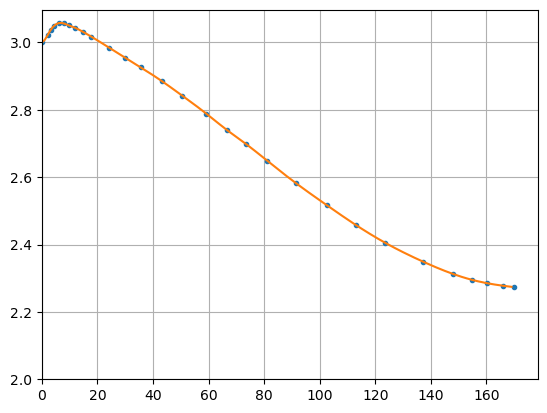

In [60]:
plt.plot(df['w_t'],df['LV'],'.')

w_t_step = 1 #mm
w_t_vector = np.arange(1e-3,max(df['w_t']),w_t_step)
LV_vector = smp.lambdify(w_t, LV_spline, "numpy")(w_t_vector)
plt.plot(w_t_vector,LV_vector)

plt.grid()
plt.ylim(bottom=2)
plt.xlim(left=0)
plt.show()

In [61]:
LV_func = lambda wheel_travel: LV_spline.subs( w_t , wheel_travel)

inv_LV = smp.lambdify(w_t, 1/LV_spline, "numpy") 

from scipy.integrate import quad
s_s_func = lambda wheel_travel: quad( inv_LV , 0 , wheel_travel )[0]

In [1571]:
chainstay=440
wheel_base=1200
rear_split= 1 - chainstay/wheel_base

mass = 80

k_spring = 70050.734 # N/m = 400 lbs/in

k_bumper = k_spring/10000  # N/m 
bumper_exponent = 5
bumper_height = 15 # milimeter

shock_max_stroke = round( s_s_func( max(df['w_t'])) , 0) 

# Damper
Rebound=10e3
LSC_preload = 0 # N
HSC_transition_velocity = 1 # m/s
LSC_slope = 5e3
HSC_transition_force= LSC_slope*HSC_transition_velocity
HSC_slope = 9e3 # N*s/m

In [1572]:
F_spring_func = lambda wheel_travel: k_spring * s_s_func(wheel_travel)/1000
    #n Newtons


F_w_spring_func = lambda wheel_travel: F_spring_func(wheel_travel) / LV_func(wheel_travel)
    # Newtons


F_bumper_func = lambda wheel_travel: k_bumper*(s_s_func(wheel_travel)-(shock_max_stroke-bumper_height))**bumper_exponent/1000 if (s_s_func(wheel_travel) > shock_max_stroke - bumper_height) else 0
    # Newtons

F_w_bumper_func = lambda wheel_travel: F_bumper_func(wheel_travel) / LV_func(wheel_travel)
    # Newtons


def F_damper_func( wheel_travel , wheel_velocity): 
    # Travel = milimeter , Velocity = meter/s

    shock_velocity = wheel_velocity / LV_func(wheel_travel)

    if shock_velocity < 0: # Rebound
        force = Rebound*shock_velocity
    elif shock_velocity<HSC_transition_velocity: # LSC
        force = LSC_preload + LSC_slope*shock_velocity
    else:
        force = LSC_preload + HSC_transition_force + HSC_slope*(shock_velocity-HSC_transition_velocity)
        
    return force
    
    
F_w_damper_func = lambda wheel_travel , wheel_velocity: F_damper_func( wheel_travel , wheel_velocity) / LV_func(wheel_travel)
    # Newtons


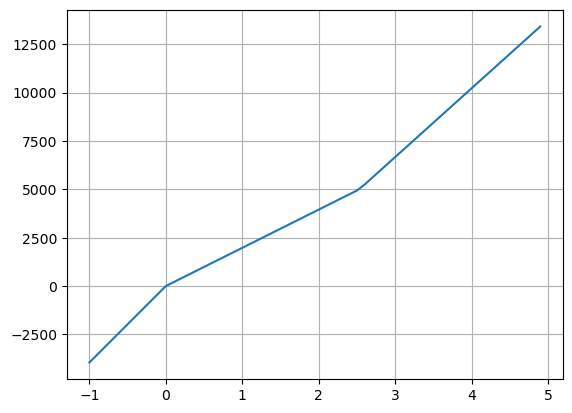

In [1573]:
velocities = np.arange(-1,5,0.1)
plt.plot(velocities , [ F_damper_func(100 , i) for i in velocities])
plt.grid()

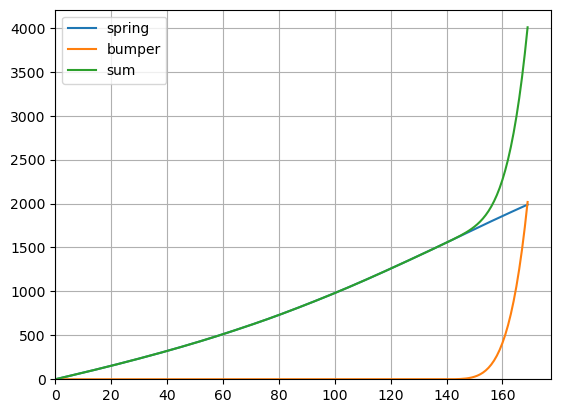

In [1577]:
"""
F_w_spring_vector = [F_w_spring_func(i) for i in w_t_vector]
F_w_bumper_vector = [F_w_bumper_func(i) for i in w_t_vector]
F_w_spring_bumper_sum = np.array(F_w_spring_vector) + np.array(F_w_bumper_vector) 

# Wheel Spring Force at bottom out
plt.plot( w_t_vector , F_w_spring_vector , label="spring")
plt.plot( w_t_vector , F_w_bumper_vector , label="bumper")
plt.plot(w_t_vector , F_w_spring_bumper_sum , label="sum")

plt.legend()
plt.grid()
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.show()
"""

In [1698]:
fall_height = 0.2

#conditions at initial ground contact
x =  w_t_vector[-1]*1e-3 #meters
v = -np.sqrt(2*9.81*fall_height)
a = 0
wheel_travel = w_t_vector[-1] - x*1e3 + 0.001 #milimeters
wheel_velocity = -v #meters

x_list=[x]
v_list=[v]
a_list=[a]
wheel_travel_list=[wheel_travel]
wheel_velocity_list=[wheel_velocity]
force_list=[0]
force_spring_bumper_list=[0]
force_damper_list=[0]

t=0
t_step=1e-5
t_final=0.1
t_list=[t]

r_mass=rear_split*mass

while (t<t_final) and (wheel_travel<w_t_vector[-1]-1) and (x<=x_list[0]) and (wheel_velocity > 0) :
    #print("x( t= ",t," ) = ",x)
    force_spring_bumper = F_w_spring_func(wheel_travel) + F_w_bumper_func(wheel_travel)
    force_damper = F_w_damper_func(wheel_travel , wheel_velocity) 
    force = force_spring_bumper + force_damper
    a = force/r_mass
    v = v + a*t_step
    x = x + v*t_step + 0.5*a*(t_step**2)
    
    wheel_travel = w_t_vector[-1] - x*1e3 #milimeters
    wheel_velocity = (wheel_travel - wheel_travel_list[-1])*1e-3/t_step #meters

    a_list.append(a)
    v_list.append(v)
    x_list.append(x)
    wheel_travel_list.append(wheel_travel)
    wheel_velocity_list.append(wheel_velocity)
    force_list.append(force)
    force_spring_bumper_list.append(force_spring_bumper)
    force_damper_list.append(force_damper)

    t += t_step
    #print("t= ",t)
    t_list.append(t)



x( t=  0  ) =  0.16900099999999998
x( t=  1e-05  ) =  0.168981194169269
x( t=  2e-05  ) =  0.168961390345936
x( t=  3.0000000000000004e-05  ) =  0.168941588749378
x( t=  4e-05  ) =  0.168921789324737
x( t=  5e-05  ) =  0.168901992071997
x( t=  6e-05  ) =  0.168882196991130
x( t=  7.000000000000001e-05  ) =  0.168862404082101
x( t=  8e-05  ) =  0.168842613344870
x( t=  9e-05  ) =  0.168822824779392
x( t=  0.0001  ) =  0.168803038385614
x( t=  0.00011  ) =  0.168783254163476
x( t=  0.00012  ) =  0.168763472112915
x( t=  0.00013000000000000002  ) =  0.168743692233861
x( t=  0.00014000000000000001  ) =  0.168723914526236
x( t=  0.00015000000000000001  ) =  0.168704138989959
x( t=  0.00016  ) =  0.168684365624942
x( t=  0.00017  ) =  0.168664594431092
x( t=  0.00018  ) =  0.168644825408309
x( t=  0.00019  ) =  0.168625058556489
x( t=  0.0002  ) =  0.168605293875522
x( t=  0.00021  ) =  0.168585531365292
x( t=  0.00022  ) =  0.168565771025678
x( t=  0.00023  ) =  0.168546012856553
x( t=  0.0

(0.0, 0.09542399999999733)

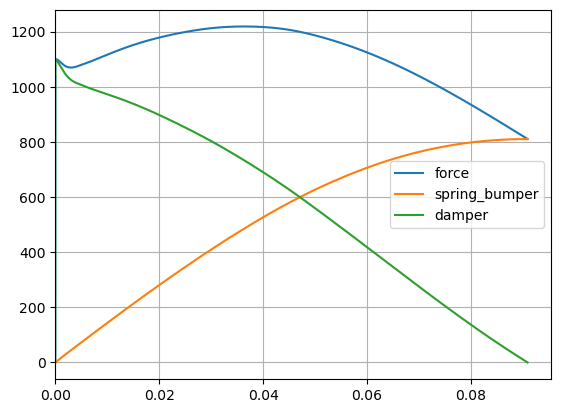

In [1699]:
plt.plot(t_list,force_list, label="force")
plt.plot(t_list,force_spring_bumper_list, label="spring_bumper")
plt.plot(t_list,force_damper_list, label="damper")
plt.legend()
plt.grid()
plt.xlim(left=0)

In [1700]:
potencial_energy = r_mass*9.81*fall_height
print("potencial_energy = ",potencial_energy)


wheel_work = sp.integrate.simpson(force_list,x_list)
print("wheel_work = ",wheel_work)

spring_energy = sp.integrate.simpson(force_spring_bumper_list,x_list)
print("spring_energy = ",spring_energy)

damper_work = sp.integrate.simpson(force_damper_list,x_list)
print("damper_work = ",damper_work)


potencial_energy =  99.40800000000002
wheel_work =  -99.3788534193700
spring_energy =  -31.9902288187036
damper_work =  -67.3886246006665


(0.0, 0.09542399999999733)

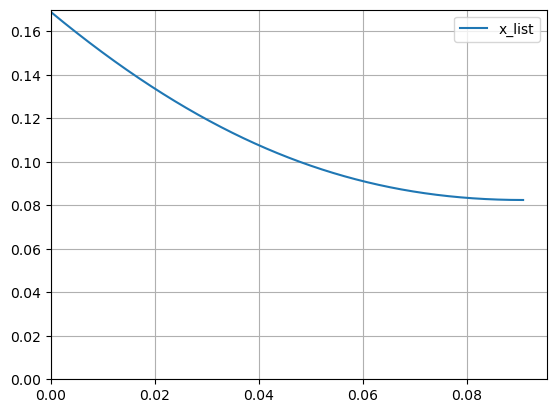

In [1701]:
plt.plot(t_list,x_list, label="x_list")
plt.grid()
plt.legend()
plt.ylim(bottom=0,top=0.170)
plt.xlim(left=0)

(0.0, 0.09542399999999733)

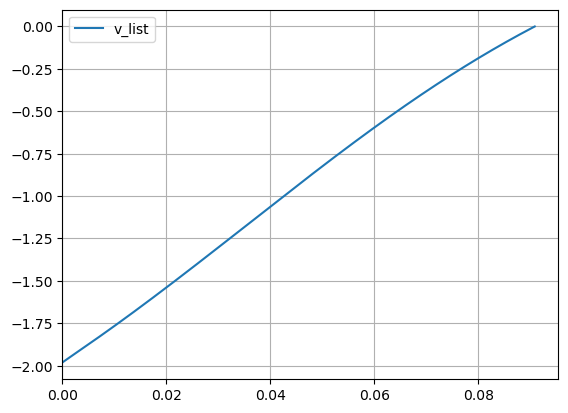

In [1702]:
plt.plot(t_list,v_list,label="v_list")
plt.grid()
plt.legend()
plt.xlim(left=0)

(0.0, 0.09542399999999733)

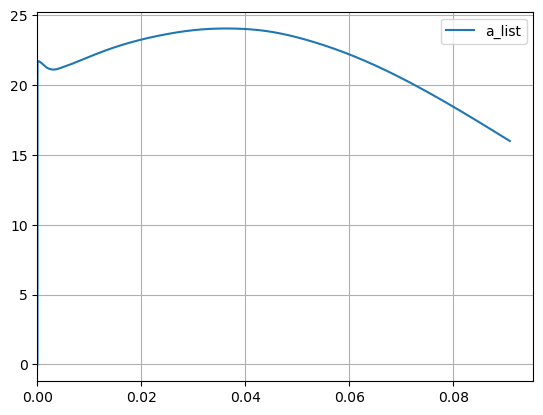

In [1703]:
plt.plot(t_list,a_list,label="a_list")
plt.grid()
plt.legend()
plt.xlim(left=0)

(0.0, 0.09542399999999733)

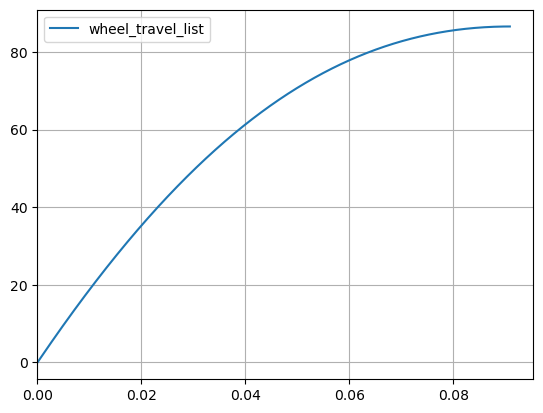

In [1704]:
plt.plot(t_list,wheel_travel_list, label="wheel_travel_list")
plt.legend()
plt.grid()
plt.xlim(left=0)

(0.0, 0.09542399999999733)

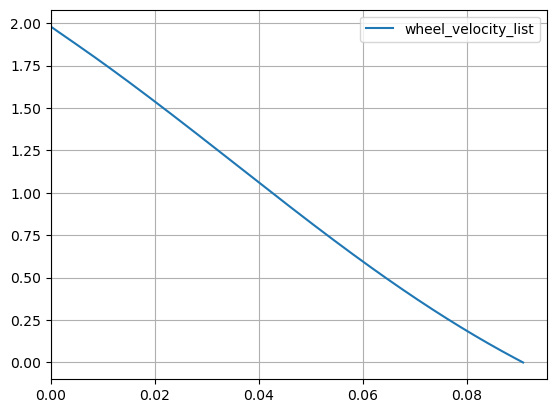

In [1705]:
plt.plot(t_list,wheel_velocity_list,label="wheel_velocity_list")
plt.legend()
plt.grid()
plt.xlim(left=0)